In [22]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool
import polars as pl
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt

# loading in the cleaned training data
#train_data = pl.read_csv('data/cleaned_training_data.csv')
#test_data = pl.read_csv('data/cleaned_test_data.csv')

In [1]:

train_data = pl.read_csv('cleaned_training_data.csv')
test_data = pl.read_csv('cleaned_test_data.csv')

# I will drop unnecessary columns
train_data = train_data.drop(['prop_log_historical_price', 'price_usd', 'parsed_date', 'year', 'month', 'day', 'search_hour', 'day_of_week', 'year_month', 'date_time', 'prop_historical_price', 'price_usd_per_night_test', 'price_ratio', 'position', 'gross_bookings_usd', 'click_bool']). \
    rename({'price_usd_without_promo': 'price_usd'})

test_data = test_data.drop(['prop_log_historical_price', 'price_usd', 'parsed_date', 'year', 'month', 'day', 'search_hour', 'day_of_week', 'year_month', 'date_time', 'prop_historical_price', 'price_usd_per_night_test', 'price_ratio']). \
    rename({'price_usd_without_promo': 'price_usd'})

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# loading in feather objects which dropped the columns listed above
train_data = pd.read_feather('data/cleaned_train_data.feather')
# test_data = pd.read_feather('cleaned_test_data.feather')')

# remove extra columns
train_data \
    .drop(['prop_review_score_filled', 'has_usable_review', 'query_affinity_score_cleaned'], axis=1, inplace=True)

# test_data \
#     .drop(['prop_review_score_filled', 'has_usable_review', 'query_affinity_score_cleaned'], axis=1, inplace=True)


In [26]:
original_train_data = train_data.copy()
original_test_data = test_data.copy()

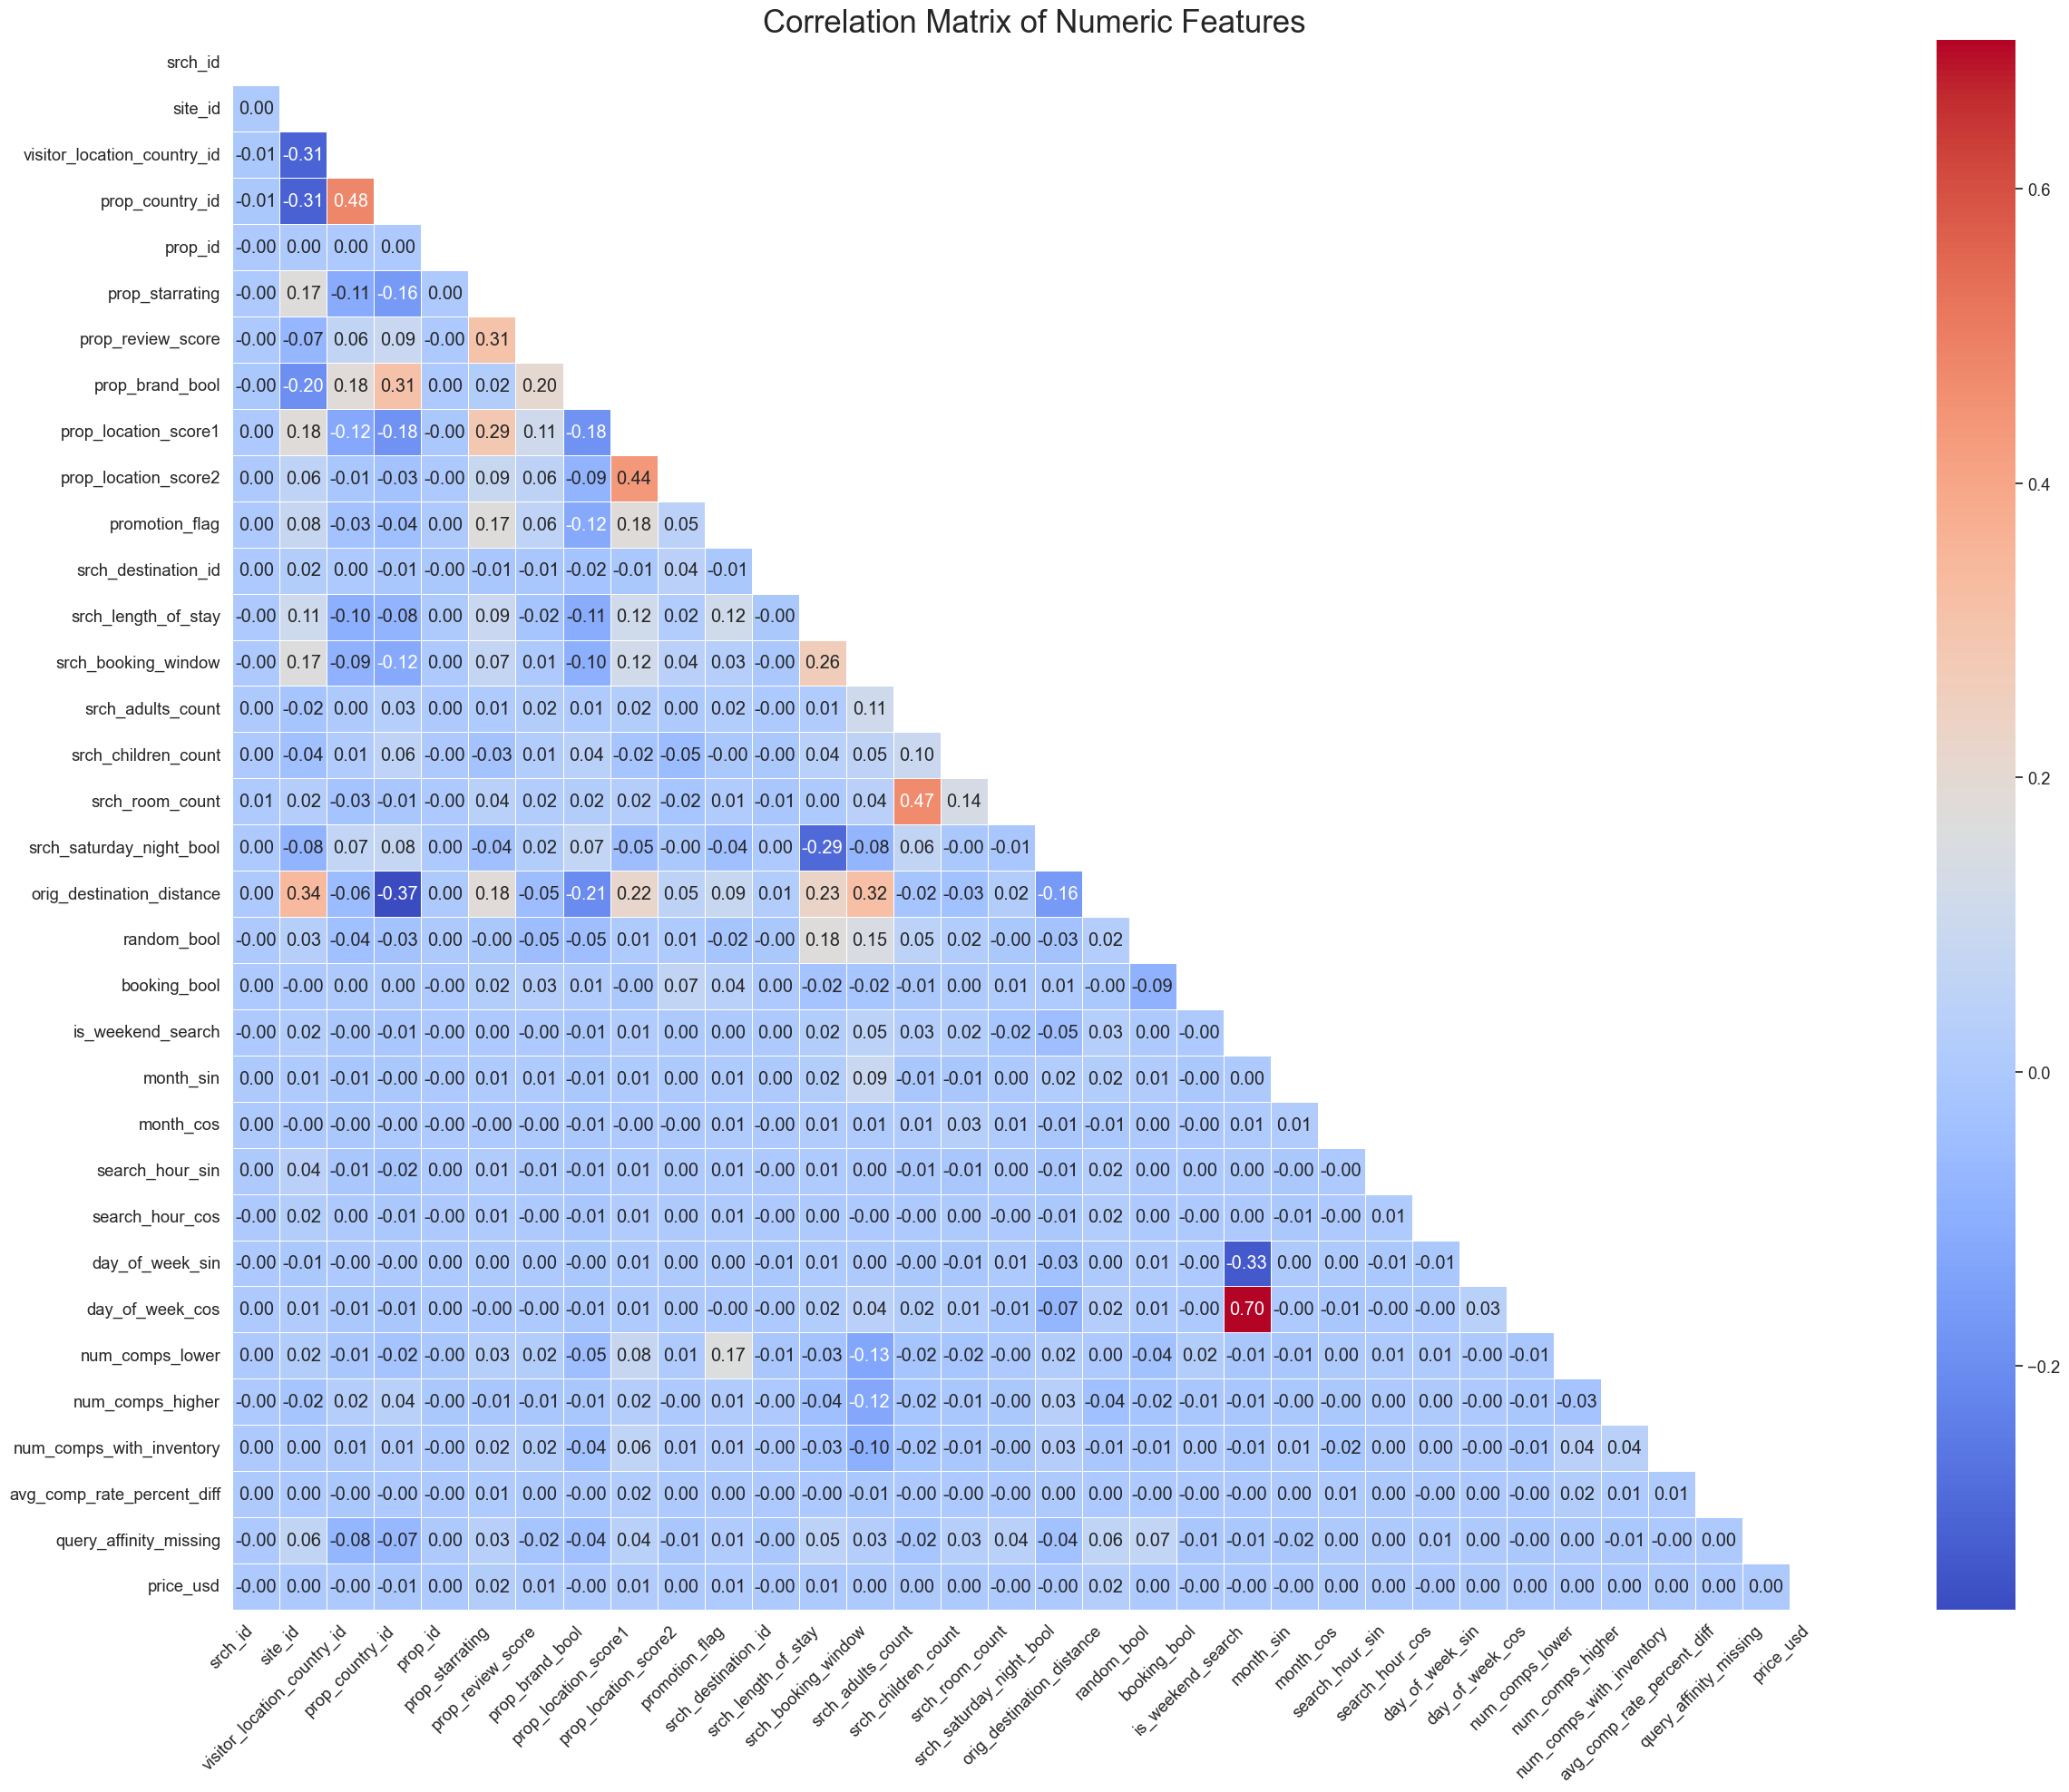

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reusing this code from GA1
correlation_data = train_data.copy()

# 1. Compute correlation matrix
cor_mat = correlation_data.select_dtypes(include=['number']).corr()

# 2. Create a mask for the upper triangle
mask = np.triu(np.ones_like(cor_mat, dtype=bool))

# 3. Set a style & context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

# 4. Set up the figure
fig, ax = plt.subplots(figsize=(25, 20))

# 5. Choose a diverging palette centered at zero
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 3. Draw the heatmap with the original cmap
sns.heatmap(
    cor_mat,
    annot=True,
    mask = mask,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,

)

# 4. Add a title if you like
plt.title("Correlation Matrix of Numeric Features", size=25)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 5. Tighten layout
plt.tight_layout()

# 6. Save to file (PNG, 300 dpi)
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

# 7. Display it
plt.show()

In [4]:
country_counts = train_data['prop_country_id'].value_counts()
country_weights = 1 / country_counts
print(country_weights)

# add weights to the training data, mapping by country code
train_data['sample_weight'] = train_data['prop_country_id'].map(country_weights)

prop_country_id
219    3.300194e-07
100    3.212511e-06
55     5.362937e-06
31     6.481427e-06
99     7.386179e-06
           ...     
180    8.333333e-02
7      1.000000e-01
126    1.428571e-01
204    2.000000e-01
165    5.000000e-01
Name: count, Length: 172, dtype: float64


In [4]:
# Convert to pandas for easier manipulation with scikit-learn
#train_df = train_data.to_pandas()
#test_df = test_data.to_pandas()

# save training and test cleaned dataframes as feathers
# train_data.write_ipc('cleaned_train_data.feather')
# test_data.write_ipc('cleaned_test_data.feather')

In [34]:
# creating the dataframe for the CatBoostRanker
#cbr_data = train_data.to_pandas().copy()
cbr_data = train_data.copy()

# I will train the model on a subset
cbr_data = cbr_data[cbr_data['srch_id'].isin(cbr_data['srch_id'].unique()[:50000])]
print(cbr_data.shape) # 2492 observations

# test model subset
test_subset = test_data.copy()
test_subset = test_subset[test_subset['srch_id'].isin(cbr_data['srch_id'])]

(1243975, 38)


In [8]:
# I will set up a CatBoostRanker. It handles numeric variables natively, so only the categorical ones need to be specified (it assumes everything else is numeric).

# this column is used as a sort of relevance feature for the ranking, as the most relevant hotels are the ones the customers actually booked. This will help the model decide what is most important
cbr_data['target'] = cbr_data['booking_bool']

# now we exclude target-only columns
exclude_cols = ['target', 'booking_bool', 'srch_id', 'prop_id']
feature_cols = [col for col in cbr_data.columns if col not in exclude_cols]

# specifying categorical features
cat_features = [col for col in cbr_data[feature_cols].columns if cbr_data[col].dtype == 'object' or 'id' in col]

# do the train/test split by group (srch_id). This is to prevent the data being split such that both the training and test sets contain the same search id
unique_srch_ids = cbr_data['srch_id'].unique()
train_srch, val_srch = train_test_split(unique_srch_ids, test_size=0.2, random_state=42)

# actually creating the training and validation sets
train_subset = cbr_data[cbr_data['srch_id'].isin(train_srch)].copy()
val_subset = cbr_data[cbr_data['srch_id'].isin(val_srch)].copy()

train_subset = train_subset.sort_values('srch_id')
val_subset = val_subset.sort_values('srch_id')

# impute missing numeric values
for col in feature_cols:
    if train_subset[col].dtype in [np.float64, np.int64]:
        train_subset[col] = train_subset[col].fillna(-999)
    if val_subset[col].dtype in [np.float64, np.int64]:
        val_subset[col] = val_subset[col].fillna(-999)

# same with categorical
for col in cat_features:
    train_subset[col] = train_subset[col].fillna('missing')
    val_subset[col] = val_subset[col].fillna('missing')

# Helper to compute group sizes
def get_group_sizes(df, group_key='srch_id'):
    return df.groupby(group_key).size().tolist()

# Group sizes for CatBoost
train_group_sizes = get_group_sizes(train_subset)
val_group_sizes = get_group_sizes(val_subset)

train_pool = Pool(
    data=train_subset[feature_cols],
    label=train_subset['target'],
    group_id=train_subset['srch_id'].astype(int).tolist(),
    cat_features=cat_features
)

val_pool = Pool(
    data=val_subset[feature_cols],
    label=val_subset['target'],
    group_id=val_subset['srch_id'].astype(int).tolist(),
    cat_features=cat_features
)

# hyperparameter optimization function using optuna
def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "loss_function": "YetiRank",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30, verbose=0)

    preds = model.predict(val_pool)

    # Evaluate using NDCG@5
    val_preds = val_subset.copy()
    val_preds['pred'] = preds
    val_preds = val_preds.sort_values(by=['srch_id', 'pred'], ascending=[True, False])

    ndcg_scores = []
    for srch_id, group in val_preds.groupby('srch_id'):
        y_true = group['target'].values
        y_score = group['pred'].values
        if len(y_true) > 1:  # NDCG isn't defined for length 1
            ndcg_scores.append(ndcg_score([y_true], [y_score], k=5))

    return np.mean(ndcg_scores)

In [9]:
# optimizing the hyperparameters. This may take a while...
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-17 14:14:52,125] A new study created in memory with name: no-name-3680557c-bffb-4948-8de9-92cd061cefc9
[I 2025-05-17 14:18:20,512] Trial 0 finished with value: 0.2683810374043468 and parameters: {'learning_rate': 0.12135972776624952, 'depth': 10, 'l2_leaf_reg': 3.3335617645086293, 'random_strength': 2.1678334242715267, 'bagging_temperature': 0.6263378646502356}. Best is trial 0 with value: 0.2683810374043468.
[I 2025-05-17 14:21:06,784] Trial 1 finished with value: 0.2682413128102511 and parameters: {'learning_rate': 0.09949034094126227, 'depth': 8, 'l2_leaf_reg': 2.1698774043657916, 'random_strength': 3.8700635817340343, 'bagging_temperature': 0.5403071674999499}. Best is trial 0 with value: 0.2683810374043468.
[I 2025-05-17 14:23:52,794] Trial 2 finished with value: 0.26713757766538043 and parameters: {'learning_rate': 0.1399389830243865, 'depth': 7, 'l2_leaf_reg': 9.284922557783096, 'random_strength': 2.339575686631948, 'bagging_temperature': 0.16293968981245965}. Best is

In [13]:
# with open('catboostranker_hyperparameters.txt', 'w') as f:
#     f.write("Hyperparameters:\n")
#     f.write(str(study.best_params))


In [11]:
# Loading in the hyperparameters
with open(f"catboostranker_hyperparameters.txt", 'r') as f:
    best_params = eval(f.read())

In [12]:
# The model will now be trained on the full dataset

# I will set up a CatBoostRanker. It handles numeric variables natively, so only the categorical ones need to be specified (it assumes everything else is numeric).

# this column is used as a sort of relevance feature for the ranking, as the most relevant hotels are the ones the customers actually booked. This will help the model decide what is most important
#train_data = train_data.to_pandas()
train_data['target'] = train_data['booking_bool']

# now we exclude target-only columns
exclude_cols = ['target', 'booking_bool', 'srch_id', 'prop_id']
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

# specifying categorical features
cat_features = [col for col in train_data[feature_cols].columns if train_data[col].dtype == 'object' or 'id' in col]

# do the train/test split by group (srch_id). This is to prevent the data being split such that both the training and test sets contain the same search id
unique_srch_ids = train_data['srch_id'].unique()
train_srch, val_srch = train_test_split(unique_srch_ids, test_size=0.2, random_state=42)

# actually creating the training and validation sets
train_subset = train_data[train_data['srch_id'].isin(train_srch)].copy()
val_subset = train_data[train_data['srch_id'].isin(val_srch)].copy()

train_subset = train_subset.sort_values('srch_id')
val_subset = val_subset.sort_values('srch_id')

# impute missing numeric values
for col in feature_cols:
    if train_subset[col].dtype in [np.float64, np.int64]:
        train_subset[col] = train_subset[col].fillna(-999)
    if val_subset[col].dtype in [np.float64, np.int64]:
        val_subset[col] = val_subset[col].fillna(-999)

# same with categorical
for col in cat_features:
    train_subset[col] = train_subset[col].fillna('missing')
    val_subset[col] = val_subset[col].fillna('missing')

# Helper to compute group sizes
def get_group_sizes(df, group_key='srch_id'):
    return df.groupby(group_key).size().tolist()

# Group sizes for CatBoost
train_group_sizes = get_group_sizes(train_subset)
val_group_sizes = get_group_sizes(val_subset)


train_pool = Pool(
    data=train_subset[feature_cols],
    label=train_subset['target'],
    group_id=train_subset['srch_id'].astype(int).tolist(),
    cat_features=cat_features
    #weight=train_subset['sample_weight']
)

val_pool = Pool(
    data=val_subset[feature_cols],
    label=val_subset['target'],
    group_id=val_subset['srch_id'].astype(int).tolist(),
    cat_features=cat_features
)

In [13]:
# applying the best hyperparameters to the model and training it
#best_params = study.best_params
best_params["iterations"] = 500
best_params["loss_function"] = "YetiRank"

model = CatBoostRanker(**best_params)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.2519532	best: 0.2519532 (0)	total: 2.74s	remaining: 22m 49s
1:	test: 0.2678285	best: 0.2678285 (1)	total: 5.08s	remaining: 21m 5s
2:	test: 0.2750615	best: 0.2750615 (2)	total: 7.41s	remaining: 20m 26s
3:	test: 0.2997590	best: 0.2997590 (3)	total: 9.35s	remaining: 19m 19s
4:	test: 0.3060542	best: 0.3060542 (4)	total: 11.8s	remaining: 19m 29s
5:	test: 0.3236723	best: 0.3236723 (5)	total: 14.4s	remaining: 19m 44s
6:	test: 0.3298308	best: 0.3298308 (6)	total: 16.6s	remaining: 19m 28s
7:	test: 0.3362184	best: 0.3362184 (7)	total: 18.8s	remaining: 19m 17s
8:	test: 0.3368455	best: 0.3368455 (8)	total: 20.9s	remaining: 19m 1s
9:	test: 0.3395552	best: 0.3395552 (9)	total: 23s	remaining: 18m 45s
10:	test: 0.3397178	best: 0.3397178 (10)	total: 25.1s	remaining: 18m 34s
11:	test: 0.3436287	best: 0.3436287 (11)	total: 27s	remaining: 18m 16s
12:	test: 0.3456635	best: 0.3456635 (12)	total: 29.1s	remaining: 18m 10s
13:	test: 0.3505344	best: 0.

In [24]:
import shap

# Step 1: Create a SHAP explainer specifically for your CatBoost model
# CatBoost has built-in SHAP support, which is more efficient than generic explainers
explainer = shap.Explainer(model)

# For ranking models, we typically want to analyze a representative sample
# since computing SHAP values for all data can be computationally expensive
# Let's take a sample from your validation set to start
sample_size = 50000  # Adjust this based on your computational resources
sample_indices = np.random.choice(len(val_subset), min(sample_size, len(val_subset)), replace=False)
val_sample = val_subset.iloc[sample_indices].copy()

# Extract the features for SHAP analysis
X_sample = val_sample[feature_cols]

# Calculate SHAP values for the sample
print("Calculating SHAP values... This may take a few minutes for ranking models.")
shap_values = explainer(X_sample)

Calculating SHAP values... This may take a few minutes for ranking models.


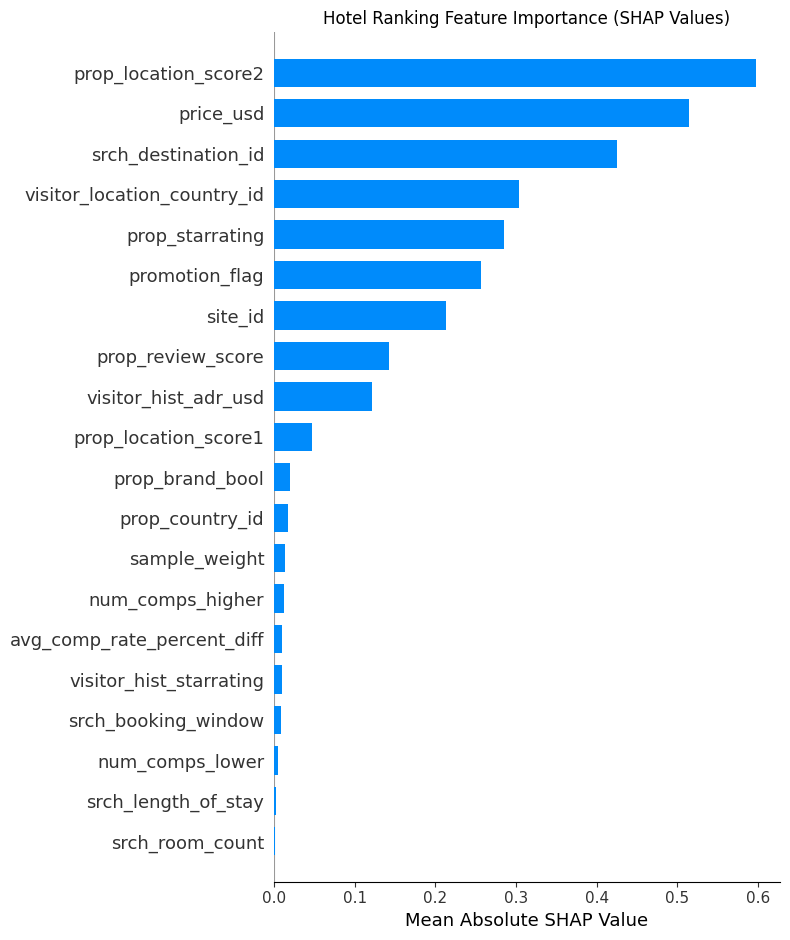

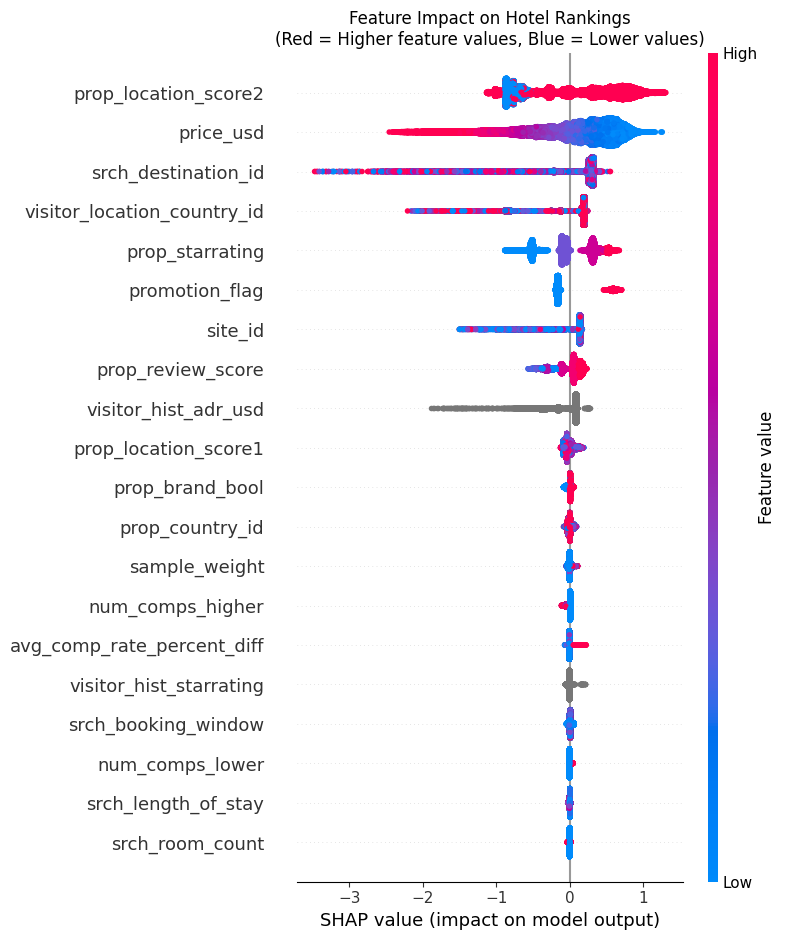

In [30]:
# 1. Feature Importance Summary
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)
plt.title("Hotel Ranking Feature Importance (SHAP Values)")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Detailed Feature Impact Plot  
shap.summary_plot(shap_values, X_sample, max_display=20, show=False)
plt.title("Feature Impact on Hotel Rankings\n(Red = Higher feature values, Blue = Lower values)")
plt.tight_layout()
plt.savefig('shap_feature_impact.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

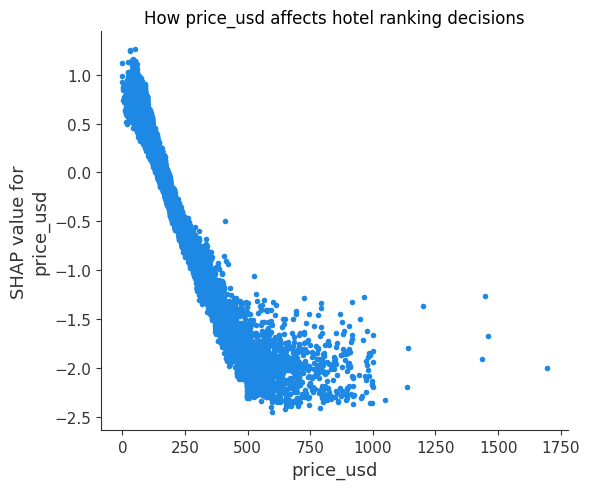

<Figure size 1000x600 with 0 Axes>

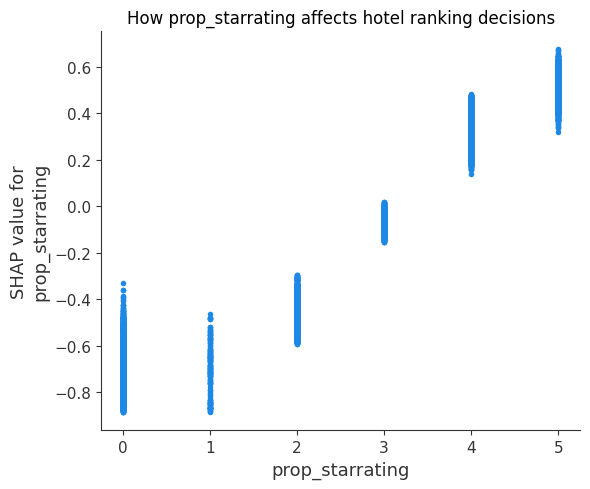

<Figure size 1000x600 with 0 Axes>

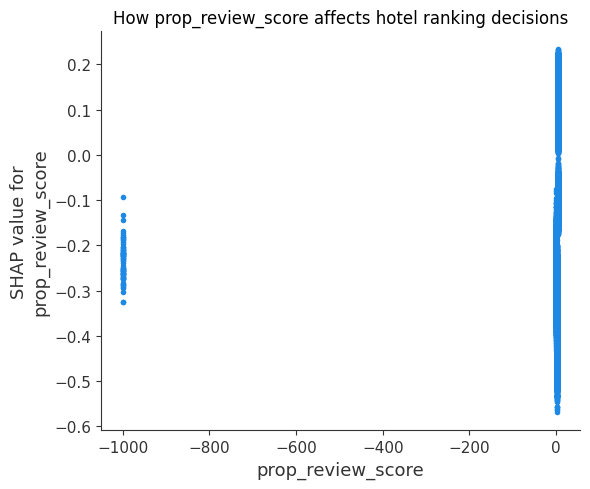

<Figure size 1000x600 with 0 Axes>

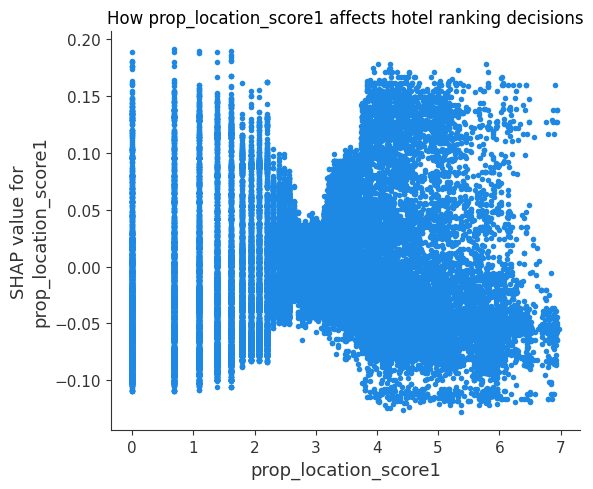

In [27]:
# 4. Feature Dependence Plots - Show how individual features behave
# These are especially useful for understanding non-linear relationships

# Let's look at some key hotel features that are likely important
important_features = ['price_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1']
available_features = [f for f in important_features if f in feature_cols]

for feature in available_features[:4]:  # Limit to first 4 to avoid too many plots
    plt.figure(figsize=(10, 6))
    feature_idx = list(X_sample.columns).index(feature)
    shap.dependence_plot(feature_idx, shap_values.values, X_sample, 
                        interaction_index=None, show=False)
    plt.title(f"How {feature} affects hotel ranking decisions")
    plt.tight_layout()
    plt.show()

In [20]:
test_subset = test_data.to_pandas().copy()

# impute missing numeric values
for col in feature_cols:
    if test_subset[col].dtype in [np.float64, np.int64]:
        test_subset[col] = test_subset[col].fillna(-999)

# same with categorical
for col in cat_features:
    test_subset[col] = test_subset[col].fillna('missing')

# Apply model on test data
test_pool = Pool(test_subset[feature_cols], group_id=test_subset['srch_id'], cat_features=cat_features)
test_subset['pred_score'] = model.predict(test_pool)

# Rank hotels for each search
ranked = test_subset.sort_values(by=['srch_id', 'pred_score'], ascending=[True, False])

# the prediction score from catboost isnt a probability, it instead is a relevance score. Converting this to a probability
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# apply softmax to the prediction scores
ranked['softmax_score'] = ranked.groupby('srch_id')['pred_score'].transform(softmax)
ranked = ranked[['srch_id', 'prop_id']]
print(ranked)

# save the ranked dataframe to a csv
ranked.to_csv('catboostranker_submission.csv', index=False)

         srch_id  prop_id
23             1    99484
9              1    54937
12             1    61934
5              1    28181
4              1    24194
...          ...      ...
4959179   332787    33959
4959178   332787    32019
4959182   332787    99509
4959181   332787    94437
4959180   332787    35240

[4959183 rows x 2 columns]
